In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import onnxruntime as ort
import pickle
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from collections import defaultdict
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [20]:
# 获取当前日期
current_date = datetime.now().strftime("%Y-%m-%d")

outdir = 'outdir'


# 构建导出的pth文件名以及ONNX文件名
pth_file_path = os.path.join(outdir, f'eeg_stress-best_model_{current_date}.pth')
onnx_file_path = os.path.join(outdir, f"eeg_stress-best_model_{current_date}.onnx")

Epoch: 0 Train Loss: 0.7150683999061584 Test Accuracy: 0.4102742910274291
Best Accuracy Model: 0.4102742910274291
Epoch: 1 Train Loss: 0.642271101474762 Test Accuracy: 0.4298000929800093
Best Accuracy Model: 0.4298000929800093
Epoch: 2 Train Loss: 0.6416955590248108 Test Accuracy: 0.5202231520223152
Best Accuracy Model: 0.5202231520223152
Epoch: 3 Train Loss: 0.6340314745903015 Test Accuracy: 0.5374244537424454
Best Accuracy Model: 0.5374244537424454
Epoch: 4 Train Loss: 0.7042590379714966 Test Accuracy: 0.5413761041376104
Best Accuracy Model: 0.5413761041376104
Epoch: 5 Train Loss: 0.6600074172019958 Test Accuracy: 0.4883774988377499
Epoch: 6 Train Loss: 0.6642541289329529 Test Accuracy: 0.5669456066945606
Best Accuracy Model: 0.5669456066945606
Epoch: 7 Train Loss: 0.6904066801071167 Test Accuracy: 0.49837284983728497
Epoch: 8 Train Loss: 0.6680330634117126 Test Accuracy: 0.5230125523012552
Epoch: 9 Train Loss: 0.6702849268913269 Test Accuracy: 0.5790330079033008
Best Accuracy Model:

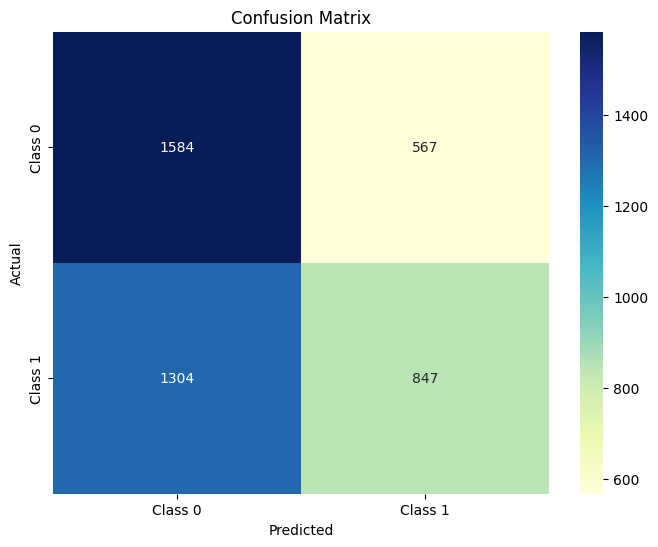

Best Accuracy Model: 0.7164109716410971


In [21]:
class CustomDataset(Dataset):
    def __init__(self, positive_file, negative_file):
        # Load positive samples
        with open(positive_file, 'rb') as f:
            self.positive_samples = pickle.load(f)
        
        # Load negative samples
        with open(negative_file, 'rb') as f:
            self.negative_samples = pickle.load(f)

        # Ensure both sets have the same length
        self.length = min(len(self.positive_samples), len(self.negative_samples))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Concatenate positive and negative samples to form a batch
        subject, positive_feature, positive_label = self.positive_samples[idx % len(self.positive_samples)]
        subject, negative_feature, negative_label = self.negative_samples[idx % len(self.negative_samples)]
        return torch.tensor(positive_feature), torch.tensor(negative_feature)

class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(128, 64)  # Input size 100, output size 64
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.5
        self.fc2 = nn.Linear(64, 32)   # Input size 64, output size 32
        self.dropout2 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.5
        self.fc3 = nn.Linear(32, 1)    # Input size 32, output size 1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Define paths to your data files
train_positive_file = './samples/train_positive_samples.pkl'
train_negative_file = './samples/train_negative_samples.pkl'
test_positive_file = './samples/test_positive_samples.pkl'
test_negative_file = './samples/test_negative_samples.pkl'

# Create datasets
train_dataset = CustomDataset(train_positive_file, train_negative_file)
test_dataset = CustomDataset(test_positive_file, test_negative_file)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss function, and optimizer
model = SimpleDNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

best_accuracy = 0.0

# Training loop
for epoch in range(100):  # Train for 10 epochs
    for batch_idx, (positive_batch, negative_batch) in enumerate(train_loader):
        # Concatenate positive and negative batches
        inputs = torch.cat((positive_batch, negative_batch), dim=0)
        labels = torch.cat((torch.ones(positive_batch.size(0), 1), torch.zeros(negative_batch.size(0), 1)), dim=0)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs.float())  # Forward pass
        loss = criterion(outputs, labels.float())  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Testing loop
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for positive_batch, negative_batch in test_loader:
            inputs = torch.cat((positive_batch, negative_batch), dim=0)
            labels = torch.cat((torch.ones(positive_batch.size(0), 1), torch.zeros(negative_batch.size(0), 1)), dim=0)
            
            outputs = model(inputs.float())
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            total_samples += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = test_correct / total_samples
    print(f'Epoch: {epoch} Train Loss: {loss} Test Accuracy: {accuracy}')

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), pth_file_path)
        print("Best Accuracy Model: {}".format(best_accuracy))

        # Export the best model to ONNX
        dummy_input = torch.randn(1, 128)
        torch.onnx.export(model, dummy_input, onnx_file_path, input_names=['input'], output_names=['output'])
    


# Load the best model
model.load_state_dict(torch.load(pth_file_path))

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)



# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
labels = ['Class 0', 'Class 1'] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print("Best Accuracy Model: {}".format(best_accuracy))


In [23]:
# 加载 ONNX 模型
onnx_model_path = './outdir/eeg_stress-best_model_2024-07-22.onnx'
ort_session = ort.InferenceSession(onnx_model_path)

# 预测函数
def predict(features):
    inputs = {ort_session.get_inputs()[0].name: features}
    outputs = ort_session.run(None, inputs)
    return outputs[0]


for filePath in [test_negative_file, test_positive_file]:
    if filePath == test_negative_file:
        print("\nTest for Negative subjects:")
    else:
        print("\nTest for Positive subjects:")

    # 加载测试数据集
    with open(filePath, 'rb') as f:
        test_data = pickle.load(f)

    # 计算每个 subject 的准确率
    subject_results = defaultdict(list)

    for subject, features, label in test_data:
        features = np.array(features, dtype=np.float32)  
        features = features.reshape(1, -1) 
        prediction = predict(features)
        predicted_label = (prediction >= 0.5).astype(int)
        subject_results[subject].append((predicted_label, label))

    subject_accuracies = {}
    for subject, results in subject_results.items():
        correct = sum(1 for pred, label in results if pred == label)
        accuracy = correct / len(results)
        subject_accuracies[subject] = accuracy

    # 输出每个 subject 的准确度
    for subject, accuracy in subject_accuracies.items():
        print(f'Subject: {subject}, Accuracy: {accuracy:.2f}')


Test for Negative subjects:
Subject: A55, Accuracy: 1.00
Subject: A47, Accuracy: 0.96
Subject: A53, Accuracy: 0.98
Subject: A04, Accuracy: 0.87

Test for Positive subjects:
Subject: A03, Accuracy: 0.62
Subject: A44, Accuracy: 0.60
Subject: A52, Accuracy: 0.20
